# Emulating realistically bad-for-cosmology SN Ia samples from PLAsTiCC data

_Alex I. Malz (GCCL@RUB)_

In [1]:
import collections
import gzip
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl

rando = 42

In [2]:
import proclam
from proclam.metrics.util import *
from proclam.metrics.util import RateMatrix

classes we care about

| `true_target`=`type` | `code` |
| -------------------- | ------ |
| 90 | SNIa |
| 67 | SNIa-91bg |
| 52 | SNIax |
| 42 | SNII |
| 62 | SNIbc |
| 95 | SLSN-I |
| 88 | AGN |

In [22]:
maybe_sn_classes = {90: 'SNIa', 
                    67: 'SNIa-91bg', 
                    52: 'SNIax', 
                    42: 'SNII', 
                    62: 'SNIbc', 
                    95: 'SLSN-I', 
                    88: 'AGN'}
maybe_sn_classes[15] = 'TDE'
maybe_sn_classes[64] = 'KN'

sel_class = 90

## gather all available lightcurves

In [4]:
datapath = '/media/RESSPECT/data/PLAsTiCC/'

other than intermediate data products, work in `/media/RESSPECT/data/PLAsTiCC/for_metrics/`

In [5]:
all_lcs = pd.read_csv(datapath+'PLAsTiCC_zenodo/plasticc_test_metadata.csv')
all_lcs = all_lcs.rename(columns={"object_id": "id", "true_z": "redshift", "true_target": "code"})

In [15]:
all_lcs

,id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,13,34.4531,-5.2295,1,0.305,0.319,0.054,41.112,0.019,0,...,0.0,0.0,60499.461,124,0.0,0.0,0.0,0.0,0.0,0.0
1,14,33.3984,-4.3311,1,-9.000,0.632,0.018,42.877,0.018,0,...,0.0,0.0,59792.121,120,0.0,0.0,0.0,0.0,0.0,0.0
2,17,348.5294,-61.7554,1,-9.000,0.830,0.060,43.600,0.016,0,...,0.0,0.0,60543.566,85,0.0,0.0,0.0,0.0,0.0,0.0
3,23,34.8047,-5.8292,1,-9.000,0.653,0.148,42.964,0.023,0,...,0.0,0.0,60137.480,97,0.0,0.0,0.0,0.0,0.0,0.0
4,34,351.3214,-64.1987,1,0.456,0.462,0.012,42.054,0.023,0,...,0.0,0.0,60245.078,68,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492885,130787966,67.5000,-23.8063,0,-9.000,0.449,0.995,41.984,0.036,0,...,0.0,0.0,60176.078,35877,0.0,0.0,0.0,0.0,0.0,0.0
3492886,130787971,98.7891,-32.9749,0,-9.000,0.673,0.061,43.042,0.083,0,...,0.0,0.0,60659.273,47200,0.0,0.0,0.0,0.0,0.0,0.0
3492887,130787974,133.9453,-21.5423,0,-9.000,0.121,0.009,38.760,0.136,0,...,0.0,0.0,60261.289,21691,0.0,0.0,0.0,0.0,0.0,0.0
3492888,130788053,199.1602,-0.8953,0,-9.000,0.429,0.262,41.863,0.028,0,...,0.0,0.0,60143.660,23710,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
field_info0 = {}
for field in ['ddf', 'wfd']:
    field_info0[field] = {}
    field_info0[field]['true_cat'] = all_lcs.loc[all_lcs['ddf_bool'] == (field == 'ddf')][['id', 'redshift', 'code']]
    field_info0[field]['n_tot_cat'] = len(field_info0[field]['true_cat'])
    field_info0[field]['n_each_cat'] = dict(field_info0[field]['true_cat'].groupby('code').count()['id'])
    print(field_info0[field]['n_each_cat'])

{6: 6, 15: 68, 16: 3, 42: 15986, 52: 807, 53: 6, 62: 2194, 64: 2, 65: 61, 67: 362, 88: 363, 90: 12640, 92: 142, 95: 98, 991: 9, 992: 31, 993: 142, 994: 6}
{6: 1297, 15: 13487, 16: 96569, 42: 984164, 52: 62857, 53: 1447, 62: 172900, 64: 131, 65: 93433, 67: 39831, 88: 101061, 90: 1647191, 92: 197013, 95: 35684, 991: 524, 992: 1671, 993: 9538, 994: 1166}


In [7]:
# n_class_pos = 3000

def gen_nums(field_info, field, n_class_pos=3000, sel_class=90, classmap=maybe_sn_classes):

    field_info[field]['pos'] = field_info[field]['n_each_cat'][sel_class]
    field_info[field]['glob'] = sum([field_info[field]['n_each_cat'][classid] for classid in classmap])
    field_info[field]['neg'] = field_info[field]['glob'] - field_info[field]['pos']
    
    n_class_glob = n_class_pos * field_info[field]['glob'] / field_info[field]['pos']
    field_info[field]['class_all'] = {classid: int(round(n_class_glob * field_info[field]['n_each_cat'][classid] / field_info[field]['glob'])) for classid in classmap}
    field_info[field]['class_glob'] = sum(field_info[field]['class_all'].values())
    print(field_info[field]['class_all'])
    
    return field_info[field].copy()

In [88]:
field_info1, field_info3, field_info6 = {}, {}, {}
field_defs = [int(1e3), int(3e3), int(6e3)]
for field in ['ddf', 'wfd']:
    field_info1[field] = gen_nums(field_info0, field, n_class_pos=field_defs[0])
    field_info3[field] = gen_nums(field_info0, field, n_class_pos=field_defs[1])
    field_info6[field] = gen_nums(field_info0, field, n_class_pos=field_defs[2])

{90: 1000, 67: 29, 52: 64, 42: 1265, 62: 174, 95: 8, 88: 29, 15: 5, 64: 0}
{90: 3000, 67: 86, 52: 192, 42: 3794, 62: 521, 95: 23, 88: 86, 15: 16, 64: 0}
{90: 6000, 67: 172, 52: 383, 42: 7588, 62: 1041, 95: 47, 88: 172, 15: 32, 64: 1}
{90: 1000, 67: 24, 52: 38, 42: 597, 62: 105, 95: 22, 88: 61, 15: 8, 64: 0}
{90: 3000, 67: 73, 52: 114, 42: 1792, 62: 315, 95: 65, 88: 184, 15: 25, 64: 0}
{90: 6000, 67: 145, 52: 229, 42: 3585, 62: 630, 95: 130, 88: 368, 15: 49, 64: 0}


TODO: sample from those that survived but use ratios from overall, SALT2 failures are class dependent/independent, cadence dependent/independent, can't disentangle (because this freebie classification criterion will not always be true with SALT3 etc., the detection ratios will depend on cadence), from our perspective contamination can't be worse, this is worst case for single contaminant

In [10]:
lc_fit_filter_ddf = pd.read_csv(datapath+'for_metrics/ddf/samples/all_objs_survived_SALT2_DDF.csv')
lc_fit_filter_wfd = pd.read_csv(datapath+'for_metrics/wfd/samples/all_objs_survived_SALT2_WFD.csv')

In [12]:
all_maybe_sn_ddf = pd.merge(lc_fit_filter_ddf['id'], all_lcs[['id', 'redshift', 'code']], on=['id'])
all_maybe_sn_wfd = pd.merge(lc_fit_filter_wfd['id'], all_lcs[['id', 'redshift', 'code']], on=['id'])

TODO: plot "confusion matrix" based on SALT2 fit success

In [89]:
all_maybe_sn = {'ddf': all_maybe_sn_ddf, 'wfd': all_maybe_sn_wfd}
for info in [field_info1, field_info3, field_info6]:
    for field in ['ddf', 'wfd']:
        count_surv = dict(all_maybe_sn[field].groupby('code').count()['id'])
        info[field]['class_avail'] = {classid: 0 for classid in maybe_sn_classes.keys()}
        for classid in maybe_sn_classes.keys():
            if classid in count_surv.keys():
                info[field]['class_avail'][classid] = count_surv[classid]
        print(info[field]['class_avail'])

{90: 10327, 67: 6, 52: 428, 42: 850, 62: 251, 95: 4, 88: 3, 15: 0, 64: 0}
{90: 933909, 67: 881, 52: 23698, 42: 59199, 62: 6066, 95: 529, 88: 1290, 15: 152, 64: 0}
{90: 10327, 67: 6, 52: 428, 42: 850, 62: 251, 95: 4, 88: 3, 15: 0, 64: 0}
{90: 933909, 67: 881, 52: 23698, 42: 59199, 62: 6066, 95: 529, 88: 1290, 15: 152, 64: 0}
{90: 10327, 67: 6, 52: 428, 42: 850, 62: 251, 95: 4, 88: 3, 15: 0, 64: 0}
{90: 933909, 67: 881, 52: 23698, 42: 59199, 62: 6066, 95: 529, 88: 1290, 15: 152, 64: 0}


~~a priori all samples will be 3000 "classified SN Ia"~~ TODO: try with `n_class_pos`=3e4, 3e5 for the three dummy cases

## subsample the classes to make new samples

TODO: maybe investigate redshift distribution of sample classified as Ia?

~~TODO: make a table of all test cases~~

In [18]:
savepath = '/media/RESSPECT/data/PLAsTiCC/for_metrics/'
savepaths = {}
for field in ['ddf', 'wfd']:
    savepaths[field] = savepath + field + '/samples/'

### get sample ids matching a confusion matrix

To calculate the true/false positive/negative rates along the way to making the subsamples, we need a notion of negatives that would never end up in the cosmology sample.
Let's use the DDF type ratios to figure out how many objects will be classified as negative for our samples of 3000 positive classifications.

`n_class_all` contains the number of objects in the true population, and the confusion matrix tells us how many will end up being classified as positive or negative

save outputs as `id,redshift,type,code,orig_sample=test,queryable=True`

In [83]:
def subsample_cat(cm, cm_indices, ntot, cat, surv=None, rando=rando,
                  pos_key=90, where_to_save=None, save_neg=True, force=False):
    if surv is None:
        surv = cat.copy()
    #     print(ntot[pos_key])
    # normalize to number in true class
#     print(cm)
    pcm = (cm.T / np.sum(cm, axis=1)).T
#     pcm = cm / np.sum(cm, axis=0)
#     print(np.sum(pcm))
    # want row corresponding to predicted class
    pos_row = pcm[cm_indices[pos_key]] * ntot[pos_key]
    pos_row = [int(round(i)) for i in pos_row]
    pos_ids, neg_ids = pd.DataFrame(columns=cat.columns), pd.DataFrame(columns=cat.columns)
    err = 0
    for typeid in cm_indices.keys():
        n_crit = len(surv[surv['code'] == typeid])
#         print((typeid, pos_row[cm_indices[typeid]], n_pos))
#         print(('debug', surv[surv['code'] == typeid]))
        
        n_pos = pos_row[cm_indices[typeid]]
        if n_pos > ntot[typeid]:
            print(f'cannot draw {n_pos} {typeid} from existing {ntot[typeid]} in {pos_row}')
            n_pos = ntot[typeid]
            err = 1
        if n_pos > n_crit:
            print(f'cannot draw {n_pos} {typeid} from surviving {n_crit} in {pos_row}')
            n_pos = n_crit
            err = 1
            
        n_neg = ntot[typeid] - n_pos
        if n_neg > ntot[typeid]:
            print(f'cannot draw {n_neg} {typeid} from negative {ntot[typeid]}')
            n_neg = ntot[typeid]
            err = 1
            
        print((n_pos, n_neg))

#         print(len(cat[cat['code'] == typeid]))
        pos = surv[surv['code'] == typeid].sample(n=n_pos, random_state=rando)
        neg = cat[cat['code'] == typeid].sample(n=n_neg, random_state=rando, replace=True)
#         pos = matches[:n_pos]
#         neg = matches[n_pos:]
        if len(pos) > 0:
            pos_ids = pos_ids.append(pos)
        if len(neg) > 0:
            neg_ids = neg_ids.append(neg)
    # special checks for edge cases on rounding errors! only matters when more than 2 classes present
    n_err = int(round(np.sum(pos_row)) - len(pos_ids))
    print('err=' + str(n_err))
    if n_err > 0:
        bonus = surv[(surv['code'] == pos_key) & (~surv.id.isin(pos.id))].sample(n=n_err, random_state=rando)
#         print(bonus)
        pos_ids = pos_ids.append(bonus)
#         print((len(pos_ids),  int(round(np.sum(pos_row)))))
#         print(pos_ids[-1 * err:])
#         neg_ids = neg_ids[err:]
#     print((len(pos_ids),  int(round(np.sum(pos_row)))))
    if n_err < 0:
        drop_indices = np.random.choice(pos_ids[pos_ids['code'] == pos_key].index, -1 * err, replace=False)
        pos_ids = pos_ids.drop(drop_indices)
    assert(len(pos_ids) == int(round(np.sum(pos_row))))
#     assert(len(pos_ids) + len(neg_ids) == np.sum(np.array([ntot[typeid] for typeid in cm_indices.keys()])))
    if where_to_save:
        if err == 1:
            where_to_save += 'fail' + str(len(pos_ids))
        pos_ids['orig_sample'] = 'test'
        pos_ids['queryable'] = True
        pos_ids['type'] = None
        pos_ids[['id','redshift','type','code','orig_sample','queryable']].to_csv(where_to_save+'.csv', index=False)
    return pos_ids, neg_ids

### realistic classifier

start from fiducial contamination rates from ~~a real (awful) confusion matrix at `/media/RESSPECT/data/PLAsTiCC/for_metrics/confusion_matrices`~~ Avocado

~~These were just the test set lightcurves for classes (67, 88, 42(minus 7?), 90(minus 11?), 52, 62, 64, 95, 15) from ddf-only~~

~~figure out classes in confusion matrix by comparing number of ddf test set-only lightcurves~~

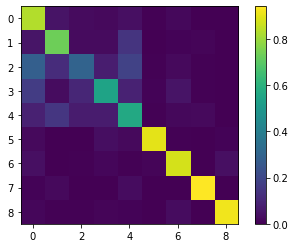

In [28]:
fid_cm = np.loadtxt('confusion_matrix_no_galactic_kb.txt')[:, :-6]
# with open(savepath+'confusion_matrices/confusion_matrix.npy', 'rb') as confmat:
#     fid_cm = np.load(confmat)
plt.imshow(fid_cm)
plt.colorbar()

In [29]:
# cm_classes = [67, 88, 42, 90, 52, 62, 64, 95, 15]
cm_classes = [90, 67, 52, 42, 62, 95, 15, 64, 88]
cm_indices = {}
for classid in maybe_sn_classes.keys():
    cm_indices[classid] = cm_classes.index(classid)

fiducial sample corresponding to input confusion matrix

In [90]:
for i, field_info in enumerate([field_info1, field_info3, field_info6]):
    for field in ['ddf', 'wfd']:
#         print(field_info[field]['class_all'])
        fiducial = subsample_cat(fid_cm, cm_indices, field_info[field]['class_all'], field_info[field]['true_cat'], surv=all_maybe_sn[field],
                             where_to_save=savepaths[field]+'fiducial'+str(field_defs[i]))
        if fiducial is not None:
            print(len(fiducial[0]))
#     print(len(fiducial[0][fiducial[0]['code'] == sel_class])+len(fiducial[1][fiducial[1]['code'] == sel_class]))
#     print((fiducial[0]['code'].value_counts(), fiducial[1]['code'].value_counts()))

(832, 168)
cannot draw 48 67 from existing 29 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
cannot draw 29 67 from surviving 6 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(6, 23)
(29, 35)
(23, 1242)
(40, 134)
cannot draw 6 95 from surviving 4 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(4, 4)
(1, 28)
cannot draw 20 15 from existing 5 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
cannot draw 5 15 from surviving 0 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(0, 5)
cannot draw 2 64 from existing 0 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(0, 0)
err=66
1001
(832, 168)
cannot draw 48 67 from existing 24 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(24, 0)
(29, 9)
(23, 574)
(40, 65)
(6, 16)
(1, 60)
cannot draw 20 15 from existing 8 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(8, 0)
cannot draw 2 64 from existing 0 in [832, 48, 29, 23, 40, 6, 20, 2, 1]
(0, 0)
err=38
1001
(2497, 503)
cannot draw 145 67 from existing 86 in [2497, 145, 87, 69, 119, 18, 59, 5, 2]
cannot draw 86 67 from surviving 6 in [2497, 145, 87, 69, 119, 18, 59, 5, 2]
(6, 80

### 100% SNIa sample

In [91]:
perf_cm = np.identity(len(cm_indices.keys()))
for i, field_info in enumerate([field_info1, field_info3, field_info6]):
    for field in ['ddf', 'wfd']:
        perfect = subsample_cat(perf_cm, cm_indices, field_info[field]['class_all'], field_info[field]['true_cat'], surv=all_maybe_sn[field],
                            where_to_save=savepaths[field]+'perfect'+str(field_defs[i]))

(1000, 0)
(0, 29)
(0, 64)
(0, 1265)
(0, 174)
(0, 8)
(0, 29)
(0, 5)
(0, 0)
err=0
(1000, 0)
(0, 24)
(0, 38)
(0, 597)
(0, 105)
(0, 22)
(0, 61)
(0, 8)
(0, 0)
err=0
(3000, 0)
(0, 86)
(0, 192)
(0, 3794)
(0, 521)
(0, 23)
(0, 86)
(0, 16)
(0, 0)
err=0
(3000, 0)
(0, 73)
(0, 114)
(0, 1792)
(0, 315)
(0, 65)
(0, 184)
(0, 25)
(0, 0)
err=0
(6000, 0)
(0, 172)
(0, 383)
(0, 7588)
(0, 1041)
(0, 47)
(0, 172)
(0, 32)
(0, 1)
err=0
(6000, 0)
(0, 145)
(0, 229)
(0, 3585)
(0, 630)
(0, 130)
(0, 368)
(0, 49)
(0, 0)
err=0


### random/guessing/uncertain classifier

In [92]:
for i, field_info in enumerate([field_info1, field_info3, field_info6]):
    for field in ['ddf', 'wfd']:
        rand_cm = np.ones((len(cm_indices.keys()), len(cm_indices.keys()))) / len(cm_indices.keys())**2
        rand_cm *= np.array([field_info[field]['n_each_cat'][key] for (key, val) in 
                         sorted(cm_indices.items(), key=lambda x: x[1])])
        rand_cm = rand_cm.T / np.sum(rand_cm)
        rand_cm *= np.array([field_info[field]['class_all'][key] for (key, val) in 
                         sorted(cm_indices.items(), key=lambda x: x[1])])
        rand_cm = rand_cm.T / np.sum(rand_cm)
        guesser = subsample_cat(rand_cm, cm_indices, field_info[field]['class_all'], field_info[field]['true_cat'], surv=all_maybe_sn[field],
                            where_to_save=savepaths[field]+'random'+str(field_defs[i]))

(389, 611)
cannot draw 11 67 from surviving 6 in [389, 11, 25, 492, 67, 3, 2, 0, 11]
(6, 23)
(25, 39)
(492, 773)
(67, 107)
(3, 5)
cannot draw 11 88 from surviving 3 in [389, 11, 25, 492, 67, 3, 2, 0, 11]
(3, 26)
cannot draw 2 15 from surviving 0 in [389, 11, 25, 492, 67, 3, 2, 0, 11]
(0, 5)
(0, 0)
err=15
(539, 461)
(13, 11)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(21, 17)
(322, 275)
(57, 48)
(12, 10)
(33, 28)
(4, 4)
(0, 0)
err=0
(1166, 1834)
cannot draw 33 67 from surviving 6 in [1166, 33, 74, 1475, 202, 9, 6, 0, 33]
(6, 80)
(74, 118)
cannot draw 1475 42 from surviving 850 in [1166, 33, 74, 1475, 202, 9, 6, 0, 33]
(850, 2944)
(202, 319)
cannot draw 9 95 from surviving 4 in [1166, 33, 74, 1475, 202, 9, 6, 0, 33]
(4, 19)
cannot draw 33 88 from surviving 3 in [1166, 33, 74, 1475, 202, 9, 6, 0, 33]
(3, 83)
cannot draw 6 15 from surviving 0 in [1166, 33, 74, 1475, 202, 9, 6, 0, 33]
(0, 16)
(0, 0)
err=693
(1616, 1384)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(39, 34)
(62, 52)
(966, 826)
(170, 145)
(35, 30)
(99, 85)
(13, 12)
(0, 0)
err=0
(2332, 3668)
cannot draw 67 67 from surviving 6 in [2332, 67, 149, 2949, 405, 18, 13, 0, 67]
(6, 166)
(149, 234)
cannot draw 2949 42 from surviving 850 in [2332, 67, 149, 2949, 405, 18, 13, 0, 67]
(850, 6738)
cannot draw 405 62 from surviving 251 in [2332, 67, 149, 2949, 405, 18, 13, 0, 67]
(251, 790)
cannot draw 18 95 from surviving 4 in [2332, 67, 149, 2949, 405, 18, 13, 0, 67]
(4, 43)
cannot draw 67 88 from surviving 3 in [2332, 67, 149, 2949, 405, 18, 13, 0, 67]
(3, 169)
cannot draw 13 15 from surviving 0 in [2332, 67, 149, 2949, 405, 18, 13, 0, 67]
(0, 32)
(0, 1)
err=2405
(3233, 2767)
(78, 67)
(123, 106)
(1931, 1654)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(339, 291)
(70, 60)
(198, 170)
(26, 23)
(0, 0)
err=0


## create new confusion matrices to tune output sample rates

consider `proclam` classifier archetypes for inspiration

In [ ]:
M_classes = len(cm_indices)

# 'Uncertain' --> 'Random'
cm_uncertain = np.ones((M_classes, M_classes))

# 'Perfect'
cm_perfect = np.eye(M_classes) + 1.e-8

# 'Almost'
cm_almost = np.eye(M_classes) + 0.1 * np.ones((M_classes, M_classes))

# 'Noisy'
cm_noisy = np.eye(M_classes) + 0.5 * np.ones((M_classes, M_classes))

# # 'Tunnel Vision'
# cm = np.ones((M_classes, M_classes))
# cm = cm * np.asarray(0.1)[np.newaxis, np.newaxis]
# cm[:, chosen] = cm[:, chosen] / M_classes
# cm[chosen][chosen] += M_classes

# # 'Cruise Control'
# cm = np.eye(M_classes) + 1.e-8
# cm[:] = cm[chosen]

# # 'Subsuming'
# cm = np.eye(M_classes) + 0.1 * np.ones((M_classes, M_classes))
# cm[chosen] = cm[chosen-1]

# # 'Mutually Subsuming'
# cm = np.eye(M_classes) + 0.1 * np.ones((M_classes, M_classes))
# cm[chosen][chosen+1] = cm[chosen][chosen]
# cm[chosen+1][chosen] = cm[chosen+1][chosen+1]

In [ ]:
# # 'Mutually Subsuming'
# target = cm_indices[sel_class]
# contaminant = cm_indices[62]
# half_ibc_cm = np.eye(M_classes) + 0.1 * np.ones((M_classes, M_classes))
# half_ibc_cm[target][contaminant] = half_ibc_cm[target][target]
# half_ibc_cm[contaminant][target] = half_ibc_cm[contaminant][contaminant]
# # plt.imshow(half_ibc_cm)
# # plt.colorbar()

make new confusion matrices as mixtures of existing ones

In [ ]:
def mix_arr(inarrs, weights=None):
    narrs = len(inarrs)
    if weights is None:
        weights = np.ones_like((1, narrs))
    arrs = inarrs / np.sum(np.sum(inarrs, axis=-1), axis=-1)[:, np.newaxis, np.newaxis]
    normwts = weights / np.sum(weights)
    outarr = np.sum(arrs * normwts[:, np.newaxis, np.newaxis], axis=0)
    return outarr

In [ ]:
# new_cm = mix_arr(np.array([cm_uncertain, cm_perfect]))
# plt.imshow(new_cm)
# plt.colorbar()

## evaluate classification metrics on the subsamples

better to do it along the way to making the subsamples, especially important for non-extreme subsamples filling the space of classification metric values

first get rates using `proclam` functionality

In [80]:
def cat_to_rate(pos_ids, neg_ids, pos_key=sel_class):
    pos_ids['classed'] = True
    neg_ids['classed'] = False
    whole_samp = pd.concat((pos_ids, neg_ids))
    whole_samp['truth'] = None
    whole_samp['truth'][whole_samp['code'] != pos_key] = False
    whole_samp['truth'][whole_samp['code'] == pos_key] = True
    bin_cm = det_to_cm(whole_samp['classed'].to_numpy(), whole_samp['truth'].to_numpy())
    rawrate = cm_to_rate(bin_cm)._asdict()
    rel_to_sel = {key: rawrate[key][0] for key in rawrate.keys()}
    rate = proclam.util.RateMatrix(**rel_to_sel)
    return rate

### calculate all the metrics!

TODO: put some version of this into `proclam` at some point!

In [79]:
class det_mets(RateMatrix):
    "binary classification metrics"
    def __init__(self, **rates):
        """
        Call like `thing = det_mets(**rates._asdict())`
        """
#         self.rates = rates#.asdict()
        self._get_tots()
        self._from_rates()
        self._sn_mets()
        self._translate()
    def _get_tots(self):
        self.CP = self.TP + self.FN
        self.CN = self.TN + self.FP
        self.T = self.TP + self.TN
        self.F = self.FP + self.FN
        self.P = self.TP + self.FP
        self.N = self.TN + self.FN
    def _from_rates(self):
        self.PPV = self.TP / (self.TP + self.FP)
        self.NPV = self.TN / (self.TN + self.FN)
        self.PT = (np.sqrt(self.TPR * (1. - self.TNR)) + self.TNR - 1.) / (self.TPR + self.TNR - 1.)
        self.TS = self.TP / (self.TP + self.FN + self.FP)
        self._derived()
    def _derived(self):
        self.ACC = (self.TP + self.TN) / (self.CP + self.CN)
        self.BA = (self.TPR + self.TNR) / 2,
        self.F1S = 2. * self.PPV * self.TPR / (self.PPV + self.TPR)
        self.MCC = (self.TP * self.TN - self.FP * self.FN) / (np.sqrt(self.P * self.CP * self.CN * self.N))
        self.FM = np.sqrt(self.PPV * self.TPR)
        self.BM = self.TPR + self.TNR - 1.
        self.MK = self.PPV + self.NPV - 1.
    def _translate(self):
        self.positive = self.CP
        self.negative = self.CN
        self.sensitivity = self.TPR
        self.recall = self.TPR
        self.specificity = self.TNR
        self.selectivity = self.TNR
        self.precision = self.PPV
        self.FDR = 1. - self.PPV
        self.FOR = 1. - self.NPV
        self.CSI = self.TS
        self.accuracy = self.ACC
        self.f1_score = self.F1S
        self.informedness = self.BM
        self.deltaP = self.MK
    def _sn_mets(self):
        self.get_efficiency()
        self.get_purity()
    def get_efficiency(self):
        self.efficiency = self.TP / self.CP
        return self.efficiency
    def get_purity(self):
        self.purity = self.TP / self.P
        return self.purity
    def get_fom(self, penalty):
        self.pseudo_purity = self.TP / (self.TP + penalty * self.FP)
        return self.pseudo_purity * self.efficiency

demonstrate on the archetypes (broken at the moment due to flagging when not enough of contaminant in "closed universe"

In [ ]:
# for field in ['ddf', 'wfd']:
#     print(field)
#     for cm in [cm_perfect, cm_almost, cm_noisy, cm_uncertain]:
#         pos, neg = subsample_cat(cm, cm_indices, field_info[field]['class_all'], field_info[field]['true_cat'])
#         rates = cat_to_rate(pos, neg)
#         mets = det_mets(**rates._asdict())
#         print(f'purity:{mets.purity}, efficiency:{mets.efficiency}, fom1:{mets.get_fom(1.)}, fom3:{mets.get_fom(3.)}')

## next, make samples corresponding to metric values

original plan was to have these samples:
- 100% Ia
- Ia/Ibc
- - 50/50
- - 75/25
- - 90/10
- - 95/5
- - 98/2
- Ia/II
- Ia/91bg
- Ia/Iax
- AGN
- TDE 
- KN

In [77]:
ia_percents = np.array([50, 68, 75, 90, 95, 98, 99])
mix_percents = 100 - ia_percents
contaminants = maybe_sn_classes.copy()
contaminants.pop(sel_class)
metpaths = {field: savepath+field+'/metrics/' for field in ['ddf', 'wfd']}

assume symmetry in 2-class mix

In [94]:
# binary_ia_mets = {}
cols = ['field', 'contaminant', 'percent'] + [key for key in RateMatrix.__dict__.keys() if key[0] != '_']
directory = pd.DataFrame(columns=cols)
field_info = field_info3
n_class_pos = field_defs[1]
for field in ['ddf', 'wfd']:
    for key, val in contaminants.items():
        subset_indices = {sel_class: 0, key: 1}
        crit = math.floor(len(all_maybe_sn[field][all_maybe_sn[field]['code'] == key]) / n_class_pos * 100)
        print(f'cannot have more than {crit} percent of {val}')
        for i, perc in enumerate(mix_percents):
            print(f'seeking {perc * n_class_pos / 100} of '+str(field_info[field]['class_all'][key]))
            if perc > crit:
#                 perc = 100 - math.floor(field_info[field]['class_all'][key] / n_class_pos * 100.)
                perc = crit
#             else:
#                 sampfn = savepaths[field]+str(ia_percents[i])+str(maybe_sn_classes[sel_class])+str(perc)+val
#                 cm = np.array([[ia_percents[i], perc], [perc, ia_percents[i]]])
            fn = str(100 - perc)+str(maybe_sn_classes[sel_class])+str(perc)+val
            sampfn = savepaths[field]+fn
            cm = np.array([[100 - perc, perc], [perc, 100 - perc]])
            pos, neg = subsample_cat(cm, subset_indices, field_info[field]['class_all'], field_info[field]['true_cat'], surv=all_maybe_sn[field], 
                                     where_to_save=sampfn)#where_to_save=None)#
            rates = cat_to_rate(pos, neg)
            mets = det_mets(**rates._asdict())
            metfn = metpaths[field]+fn#f'{100-perc}_{sel_class}_{perc}_{key}'
            print(f'{metfn} = F1:{mets.f1_score}, purity:{mets.purity}, efficiency:{mets.efficiency}, fom1:{mets.get_fom(1.)}, fom3:{mets.get_fom(3.)}')
            with open(metfn+'.pkl', 'wb') as metfile:
                pkl.dump(rates._asdict(), metfile)
            thisloc = len(directory)        
            directory.loc[thisloc] = [field, val, perc] + [rates._asdict()[key] for key in rates._asdict().keys()]
directory.to_csv(savepath+'directory.csv', index=False)

cannot have more than 0 percent of SNIa-91bg
seeking 1500.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 960.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

seeking 750.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 300.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 150.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 60.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 30.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SNIa-91bg = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
cannot have more than 14 percent of SNIax
seeking 1500.0 of 192
(2580, 420)
cannot draw 420 52 from existing 192 in [2580, 420]
(192, 0)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

cannot draw 420 52 from existing 192 in [2580, 420]
(192, 0)
err=228
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/86SNIa14SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 192
(2580, 420)
cannot draw 420 52 from existing 192 in [2580, 420]
(192, 0)
err=228
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/86SNIa14SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 300.0 of 192
(2700, 300)
cannot draw 300 52 from existing 192 in [2700, 300]
(192, 0)
err=108
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/90SNIa10SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 150.0 of 192
(2850, 150)
(150, 42)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/95SNIa5SNIax = F1:0.21875, purity:0.21875, efficiency:0.21875, fom1:0.0478515625, fom3:0.01867378048780488
seeking 60.0 of 192
(2940, 60)
(60, 132)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/98SNIa2SNIax = F1:0.6875, purity:0.6875, 

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

cannot have more than 28 percent of SNII
seeking 1500.0 of 3794
(2160, 840)
(840, 2954)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/72SNIa28SNII = F1:0.7785977859778597, purity:0.7785977859778598, efficiency:0.7785977859778598, fom1:0.6062145123296251, fom3:0.4201640226120931
seeking 960.0 of 3794
(2160, 840)
(840, 2954)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/72SNIa28SNII = F1:0.7785977859778597, purity:0.7785977859778598, efficiency:0.7785977859778598, fom1:0.6062145123296251, fom3:0.4201640226120931
seeking 750.0 of 3794
(2250, 750)
(750, 3044)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/75SNIa25SNII = F1:0.8023194517659462, purity:0.8023194517659462, efficiency:0.8023194517659462, fom1:0.6437165026820085, fom3:0.4613261071355384
seeking 300.0 of 3794
(2700, 300)
(300, 3494)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/90SNIa10SNII = F1:0.9209277807063785, purity:0.9209277807063785, efficiency:0.9209277807063785, fom

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/98SNIa2SNII = F1:0.9841855561412757, purity:0.9841855561412757, efficiency:0.9841855561412757, fom1:0.9686212089171121, fom3:0.9389240844740735
seeking 30.0 of 3794
(2970, 30)
(30, 3764)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/99SNIa1SNII = F1:0.9920927780706379, purity:0.9920927780706379, efficiency:0.9920927780706379, fom1:0.984248080299916, fom3:0.9689250691899017
cannot have more than 8 percent of SNIbc
seeking 1500.0 of 521
(2760, 240)
(240, 281)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/92SNIa8SNIbc = F1:0.5393474088291746, purity:0.5393474088291746, efficiency:0.5393474088291746, fom1:0.2908956274107449, fom3:0.15140521666433374
seeking 960.0 of 521
(2760, 240)
(240, 281)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/92SNIa8SNIbc = F1:0.5393474088291746, purity:0.5393474088291746, efficiency:0.5393474088291746, fom1:0.2908956274107449, fom3:0.15140521666433374
seeking 750.0 

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/92SNIa8SNIbc = F1:0.5393474088291746, purity:0.5393474088291746, efficiency:0.5393474088291746, fom1:0.2908956274107449, fom3:0.15140521666433374
seeking 150.0 of 521
(2850, 150)
(150, 371)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/95SNIa5SNIbc = F1:0.7120921305182343, purity:0.7120921305182342, efficiency:0.7120921305182342, fom1:0.5070752023459979, fom3:0.3217858470429536
seeking 60.0 of 521
(2940, 60)
(60, 461)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/98SNIa2SNIbc = F1:0.8848368522072937, purity:0.8848368522072937, efficiency:0.8848368522072937, fom1:0.7829362550241121, fom3:0.6363647252224063
seeking 30.0 of 521
(2970, 30)
(30, 491)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/99SNIa1SNIbc = F1:0.9424184261036468, purity:0.9424184261036468, efficiency:0.9424184261036468, fom1:0.8881524898596748, fom3:0.7964327835058358
cannot have more than 0 percent of SLSN-I
seeking 1500.0 of

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SLSN-I = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 150.0 of 23
(3000, 0)
(0, 23)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SLSN-I = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 60.0 of 23
(3000, 0)
(0, 23)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SLSN-I = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 30.0 of 23
(3000, 0)
(0, 23)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0SLSN-I = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
cannot have more than 0 percent of AGN
seeking 1500.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0AGN = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 960.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0AGN = F1:1.0, purity:1.0, efficiency:1.0, fom1:

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

seeking 300.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0AGN = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 150.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0AGN = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 60.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0AGN = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 30.0 of 86
(3000, 0)
(0, 86)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0AGN = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
cannot have more than 0 percent of TDE
seeking 1500.0 of 16
(3000, 0)
(0, 16)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 960.0 of 16
(3000, 0)
(0, 16)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 300.0 of 16
(3000, 0)
(0, 16)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 150.0 of 16
(3000, 0)
(0, 16)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 60.0 of 16
(3000, 0)
(0, 16)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
seeking 30.0 of 16
(3000, 0)
(0, 16)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0TDE = F1:1.0, purity:1.0, efficiency:1.0, fom1:1.0, fom3:1.0
cannot have more than 0 percent of KN
seeking 1500.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 

/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 300.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 150.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 60.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 30.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
cannot have more than 29 percent of SNIa-91bg
seeking 1500.0 of 73
(2130, 870)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:177: RuntimeWarning: invalid value encountered in true_divide
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:178: RuntimeWarning: invalid value encountered in true

cannot draw 870 67 from existing 73 in [2130, 870]
(73, 0)
err=797
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/71SNIa29SNIa-91bg = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 960.0 of 73
(2130, 870)
cannot draw 870 67 from existing 73 in [2130, 870]
(73, 0)
err=797


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/71SNIa29SNIa-91bg = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 73
(2250, 750)
cannot draw 750 67 from existing 73 in [2250, 750]
(73, 0)
err=677
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/75SNIa25SNIa-91bg = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 300.0 of 73
(2700, 300)
cannot draw 300 67 from existing 73 in [2700, 300]
(73, 0)
err=227
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/90SNIa10SNIa-91bg = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 150.0 of 73
(2850, 150)
cannot draw 150 67 from existing 73 in [2850, 150]
(73, 0)
err=77


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5SNIa-91bg = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 60.0 of 73
(2940, 60)
(60, 13)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2SNIa-91bg = F1:0.17808219178082194, purity:0.1780821917808219, efficiency:0.1780821917808219, fom1:0.03171326702946144, fom3:0.011995173539640854
seeking 30.0 of 73
(2970, 30)
(30, 43)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1SNIa-91bg = F1:0.589041095890411, purity:0.589041095890411, efficiency:0.589041095890411, fom1:0.34696941264777637, fom3:0.1904418580698321
cannot have more than 789 percent of SNIax
seeking 1500.0 of 114
(1500, 1500)
cannot draw 1500 52 from existing 114 in [1500, 1500]
(114, 0)
err=1386


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/50SNIa50SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 960.0 of 114
(2040, 960)
cannot draw 960 52 from existing 114 in [2040, 960]
(114, 0)
err=846


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/68SNIa32SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 114
(2250, 750)
cannot draw 750 52 from existing 114 in [2250, 750]
(114, 0)
err=636
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/75SNIa25SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


seeking 300.0 of 114
(2700, 300)
cannot draw 300 52 from existing 114 in [2700, 300]
(114, 0)
err=186
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/90SNIa10SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 150.0 of 114
(2850, 150)
cannot draw 150 52 from existing 114 in [2850, 150]
(114, 0)
err=36
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5SNIax = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 60.0 of 114
(2940, 60)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

(60, 54)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2SNIax = F1:0.47368421052631576, purity:0.47368421052631576, efficiency:0.47368421052631576, fom1:0.22437673130193903, fom3:0.10931174089068826
seeking 30.0 of 114
(2970, 30)
(30, 84)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1SNIax = F1:0.7368421052631579, purity:0.7368421052631579, efficiency:0.7368421052631579, fom1:0.5429362880886426, fom3:0.3557168784029038
cannot have more than 1973 percent of SNII
seeking 1500.0 of 1792
(1500, 1500)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

(1500, 292)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/50SNIa50SNII = F1:0.16294642857142858, purity:0.16294642857142858, efficiency:0.16294642857142858, fom1:0.026551538584183673, fom3:0.009929122943000239
seeking 960.0 of 1792
(2040, 960)
(960, 832)
err=0


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/68SNIa32SNII = F1:0.4642857142857143, purity:0.4642857142857143, efficiency:0.4642857142857143, fom1:0.21556122448979592, fom3:0.104064039408867
seeking 750.0 of 1792
(2250, 750)
(750, 1042)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/75SNIa25SNII = F1:0.5814732142857143, purity:0.5814732142857143, efficiency:0.5814732142857143, fom1:0.3381110989317602, fom3:0.18405075616212463
seeking 300.0 of 1792
(2700, 300)
(300, 1492)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/90SNIa10SNII = F1:0.8325892857142857, purity:0.8325892857142857, efficiency:0.8325892857142857, fom1:0.6932049186862245, fom3:0.5193240862398472
seeking 150.0 of 1792
(2850, 150)
(150, 1642)
err=0


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5SNII = F1:0.9162946428571429, purity:0.9162946428571429, efficiency:0.9162946428571429, fom1:0.839595872528699, fom3:0.7191949347855777
seeking 60.0 of 1792
(2940, 60)
(60, 1732)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2SNII = F1:0.9665178571428571, purity:0.9665178571428571, efficiency:0.9665178571428571, fom1:0.9341567681760203, fom3:0.8755276823072324
seeking 30.0 of 1792
(2970, 30)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

(30, 1762)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1SNII = F1:0.9832589285714286, purity:0.9832589285714286, efficiency:0.9832589285714286, fom1:0.9667981206154337, fom3:0.9354763672477631
cannot have more than 202 percent of SNIbc
seeking 1500.0 of 315
(1500, 1500)
cannot draw 1500 62 from existing 315 in [1500, 1500]
(315, 0)
err=1185


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/50SNIa50SNIbc = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 960.0 of 315
(2040, 960)
cannot draw 960 62 from existing 315 in [2040, 960]
(315, 0)
err=645


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/68SNIa32SNIbc = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 315
(2250, 750)
cannot draw 750 62 from existing 315 in [2250, 750]
(315, 0)
err=435


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/75SNIa25SNIbc = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 300.0 of 315
(2700, 300)
(300, 15)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/90SNIa10SNIbc = F1:0.047619047619047616, purity:0.047619047619047616, efficiency:0.047619047619047616, fom1:0.0022675736961451243, fom3:0.00078064012490242
seeking 150.0 of 315
(2850, 150)
(150, 165)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5SNIbc = F1:0.5238095238095238, purity:0.5238095238095238, efficiency:0.5238095238095238, fom1:0.2743764172335601, fom3:0.140534262485482
seeking 60.0 of 315
(2940, 60)
(60, 255)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2SNIbc = F1:0.8095238095238095, purity:0.8095238095238095, efficiency:0.8095238095238095, fom1:0.655328798185941, fom3:0.4745484400656814
seeking 30.0 of 315
(2970, 30)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

(30, 285)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1SNIbc = F1:0.9047619047619048, purity:0.9047619047619048, efficiency:0.9047619047619048, fom1:0.8185941043083901, fom3:0.6876190476190477
cannot have more than 17 percent of SLSN-I
seeking 1500.0 of 65
(2490, 510)
cannot draw 510 95 from existing 65 in [2490, 510]
(65, 0)
err=445


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/83SNIa17SLSN-I = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 960.0 of 65
(2490, 510)
cannot draw 510 95 from existing 65 in [2490, 510]
(65, 0)
err=445
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/83SNIa17SLSN-I = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 65
(2490, 510)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

cannot draw 510 95 from existing 65 in [2490, 510]
(65, 0)
err=445
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/83SNIa17SLSN-I = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 300.0 of 65
(2700, 300)
cannot draw 300 95 from existing 65 in [2700, 300]
(65, 0)
err=235


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/90SNIa10SLSN-I = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 150.0 of 65
(2850, 150)
cannot draw 150 95 from existing 65 in [2850, 150]
(65, 0)
err=85
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5SLSN-I = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 60.0 of 65
(2940, 60)
(60, 5)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2SLSN-I = F1:0.07692307692307693, purity:0.07692307692307693, efficiency:0.07692307692307693, fom1:0.00591715976331361, fom3:0.002079002079002079
seeking 30.0 of 65
(2970, 30)
(30, 35)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1SLSN-I = F1:0.5384615384615384, purity:0.5384615384615384, efficiency:0.5384615384615384, fom1:0.28994082840236685, fom3:0.15076923076923077
cannot have more than 43 percent of AGN
seeking 1500.0 of 184
(1710, 1290)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

cannot draw 1290 88 from existing 184 in [1710, 1290]
(184, 0)
err=1106
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/57SNIa43AGN = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 960.0 of 184
(2040, 960)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


cannot draw 960 88 from existing 184 in [2040, 960]
(184, 0)
err=776
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/68SNIa32AGN = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 184
(2250, 750)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


cannot draw 750 88 from existing 184 in [2250, 750]
(184, 0)
err=566
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/75SNIa25AGN = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 300.0 of 184
(2700, 300)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


cannot draw 300 88 from existing 184 in [2700, 300]
(184, 0)
err=116
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/90SNIa10AGN = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 150.0 of 184
(2850, 150)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

(150, 34)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5AGN = F1:0.18478260869565213, purity:0.18478260869565216, efficiency:0.18478260869565216, fom1:0.0341446124763705, fom3:0.012980596478620194
seeking 60.0 of 184
(2940, 60)
(60, 124)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2AGN = F1:0.6739130434782609, purity:0.6739130434782609, efficiency:0.6739130434782609, fom1:0.45415879017013233, fom3:0.2748855835240275
seeking 30.0 of 184
(2970, 30)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cos

(30, 154)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1AGN = F1:0.8369565217391305, purity:0.8369565217391305, efficiency:0.8369565217391305, fom1:0.7004962192816636, fom3:0.5282430506058446
cannot have more than 5 percent of TDE
seeking 1500.0 of 25
(2850, 150)
cannot draw 150 15 from existing 25 in [2850, 150]
(25, 0)
err=125
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 960.0 of 25


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

(2850, 150)
cannot draw 150 15 from existing 25 in [2850, 150]
(25, 0)
err=125
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 750.0 of 25
(2850, 150)
cannot draw 150 15 from existing 25 in [2850, 150]
(25, 0)
err=125
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 300.0 of 25
(2850, 150)
cannot draw 150 15 from existing 25 in [2850, 150]
(25, 0)
err=125


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 150.0 of 25
(2850, 150)
cannot draw 150 15 from existing 25 in [2850, 150]
(25, 0)
err=125
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/95SNIa5TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 60.0 of 25
(2940, 60)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

cannot draw 60 15 from existing 25 in [2940, 60]
(25, 0)
err=35
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/98SNIa2TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
seeking 30.0 of 25
(2970, 30)
cannot draw 30 15 from existing 25 in [2970, 30]
(25, 0)
err=5


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/99SNIa1TDE = F1:nan, purity:0.0, efficiency:0.0, fom1:0.0, fom3:0.0
cannot have more than 0 percent of KN
seeking 1500.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 960.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 750.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 300.0 of 0
(3000, 0)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:177: RuntimeWarning: invalid value encountered in true_divide
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:178: RuntimeWarning: invalid value encountered in true

(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 150.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 60.0 of 0
(3000, 0)


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:177: RuntimeWarning: invalid value encountered in true_divide
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:178: RuntimeWarning: invalid value encountered in true

(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan
seeking 30.0 of 0
(3000, 0)
(0, 0)
err=0
/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/metrics/100SNIa0KN = F1:nan, purity:nan, efficiency:nan, fom1:nan, fom3:nan


/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:177: RuntimeWarning: invalid value encountered in true_divide
/media/CRP6/Cosmology/ve3_recidivator/lib/python3.6/site-packages/proclam-0.1-py3.6.egg/proclam/metrics/util.py:178: RuntimeWarning: invalid value encountered in true

TODO: consider nontrivial mixes